<a href="https://colab.research.google.com/github/patrikviszt/unsupervisedLearning/blob/main/movieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import warnings

In [5]:
from google.colab import files
uploaded = files.upload()

In [7]:
data_column = ['user_id', 'item_id', 'rating', 'timestamp']
userdata = pd.read_csv('u.data', sep='\t', names=data_column)
userdata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
user_column = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user = pd.read_csv('u.user', sep ='|', names=user_column)
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [9]:
item_column = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
item = pd.read_csv('u.item', sep='|',names=item_column, encoding='latin1', usecols=[0,1,2,3,4])
item['release_date'] = pd.to_datetime(item['release_date'], format='%d-%b-%Y', errors='coerce')
item['video_release_date'] = pd.to_datetime(item['video_release_date'], format='%d-%b-%Y', errors='coerce')

item.head()

,item_id,movie_title,release_date,video_release_date,IMDb_URL
0,1,Toy Story (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),1995-01-01,NaT,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [10]:
print(f"összes felhasználó száma: {userdata['user_id'].nunique()}")
print(f"összes film száma: {item['item_id'].nunique()}")

összes felhasználó száma: 943
összes film száma: 1682


In [11]:
rating_count = userdata['rating'].value_counts().sort_index()
print("Értékelések eloszlása:", rating_count)

Értékelések eloszlása: rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


Ajánlórendszer alapok

In [12]:
pivot_table = userdata.pivot_table(index='user_id', columns='item_id', values='rating')
pivot_table.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Felhasználó alapú hasonlóság

In [13]:
movie_data = pd.merge(userdata, item, on='item_id')

In [16]:
user_movie_rating = movie_data.pivot_table(index='user_id', columns='movie_title', values='rating')
user_movie_rating_fillled = user_movie_rating.fillna(0)

In [18]:
user_similarity = cosine_similarity(pivot_table.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table.index, columns=pivot_table.index)
user_similarity_df.head()



user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


Film alapú hasonlóság

In [ ]:
item_similarity = cosine_similarity(pivot_table.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table.columns, columns = pivot_table.columns)
item_similarity_df.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
2,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
3,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
4,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
5,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


Ajánlás egy adott felhasználónak

In [24]:
target_user_id=5
similar_users=user_similarity_df[target_user_id].sort_values(ascending=False)
unrated_movies = user_movie_rating.loc[target_user_id][user_movie_rating.loc[target_user_id].isnull()].index
similar_users_ratings = user_movie_rating_fillled.loc[similar_users.index].drop(columns=user_movie_rating.columns.difference(unrated_movies))
weighted_ratings = similar_users_ratings.mul(similar_users, axis=0)
predicted_ratings = weighted_ratings.sum(axis=0) / similar_users.sum()
recommendations = predicted_ratings.sort_values(ascending=False)

In [27]:
print(f"Ajánlott filmek a(z) {target_user_id}. felhasználó számára:")
print(recommendations.head(10))

Ajánlott filmek a(z) 5. felhasználó számára:
movie_title
Pulp Fiction (1994)                  2.597649
Godfather, The (1972)                2.381171
Twelve Monkeys (1995)                2.200992
Terminator, The (1984)               2.180792
Terminator 2: Judgment Day (1991)    2.136835
Braveheart (1995)                    2.085642
Contact (1997)                       2.067793
Schindler's List (1993)              2.052862
Shawshank Redemption, The (1994)     2.036645
Rock, The (1996)                     1.997473
dtype: float64


Felhasználók csoportosítása értékelések alapján

In [30]:
user_ratings_for_clustering = user_movie_rating_fillled.copy()

In [31]:
scaler = StandardScaler()
scaled_user_ratings=scaler.fit_transform(user_ratings_for_clustering)

In [32]:
n_clusters=5
kmeans=KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(scaled_user_ratings)

In [33]:
user['cluster'] = user['user_id'].map(dict(zip(user_movie_rating.index, user_clusters)))
print("\nFelhasználók és a hozzájuk rendelt klaszterek (első néhány sor):")
print(user[['user_id', 'occupation', 'cluster']].head())


Felhasználók és a hozzájuk rendelt klaszterek (első néhány sor):
   user_id  occupation  cluster
0        1  technician        2
1        2       other        3
2        3      writer        3
3        4  technician        3
4        5       other        2


In [34]:
cluster_counts = user['cluster'].value_counts().sort_index()
print("\nFelhasználók száma az egyes klaszterekben:")
print(cluster_counts)


Felhasználók száma az egyes klaszterekben:
cluster
0      1
1     50
2    232
3    659
4      1
Name: count, dtype: int64


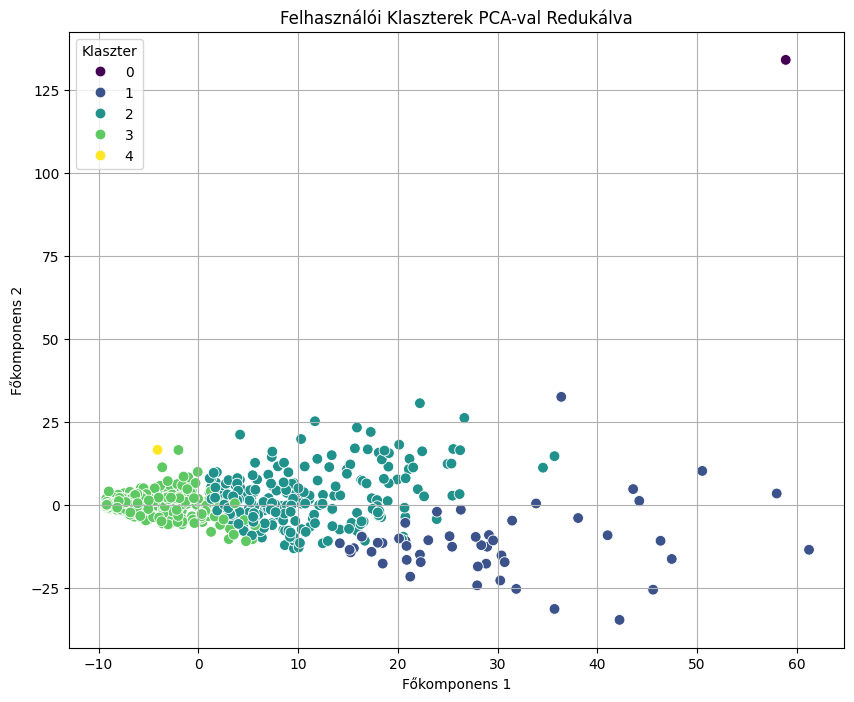

In [35]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_user_ratings)
pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])
pca_df['cluster'] = user['cluster'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal_component_1', y='principal_component_2', hue='cluster', data=pca_df, palette='viridis', s=60)
plt.title('Felhasználói Klaszterek PCA-val Redukálva')
plt.xlabel('Főkomponens 1')
plt.ylabel('Főkomponens 2')
plt.legend(title='Klaszter')
plt.grid(True)
plt.show()